In [1]:
from typing import Dict, List
import glob
import yaml
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
auxs = ["bisim", "bisim_critic"]

envs = []
with open("envs.txt", "r") as envs_file:
    for line in envs_file:
        stripped = line.strip()
        if stripped != "":
            envs.append(stripped)
distracted_envs = [env + "-d32" for env in envs]

In [3]:
def get_results(log_path: str) -> Dict[str, Dict[str, Dict[str, pd.DataFrame]]]:
    results = dict()
    cfg_paths = glob.glob(f"./{log_path}/**/flags.yml", recursive=True)
    for cfg_path in cfg_paths:
        res_path = cfg_path.replace("flags.yml", "progress.csv")
        with open(cfg_path, "r") as cfg_file:
            cfg = yaml.safe_load(cfg_file)
            aux = cfg["aux"]
            env = cfg_path.split("/")[2]

            if env not in results:
                results[env] = dict()
            if aux not in results[env]:
                results[env][aux] = dict()
            results[env][aux][res_path] = pd.read_csv(res_path)
    return results


def plot_results(
    envs: List[str],
    auxs: List[str],
    results: Dict[str, Dict[str, Dict[str, pd.DataFrame]]],
    target: str,
) -> None:
    if math.sqrt(len(envs)).is_integer():
        subplot_rows = int(math.sqrt(len(envs)))
        subplot_cols = int(math.sqrt(len(envs)))
    else:
        subplot_rows = 1
        subplot_cols = len(envs)

    plt.figure(figsize=(8, 10))

    for subplot_idx, env in enumerate(envs):
        plt.subplot(subplot_rows, subplot_cols, subplot_idx + 1)

        legend = []
        for aux in auxs:
            n_exps = len(results[env][aux])
            for exp_idx, (res_path, df) in enumerate(results[env][aux].items()):
                if target not in df.columns:
                    continue
                valid_idxs = ~df[target].isna()
                env_steps = df["env_steps"][valid_idxs]
                target_values = df[target][valid_idxs]
                plt.plot(env_steps, target_values, label=res_path)

                if n_exps == 1:
                    legend.append(f"{aux}")
                else:
                    legend.append(f"{aux}_{exp_idx}")

        plt.title(f"{target.title()} for {env}")
        plt.xlabel("env_steps")
        plt.ylabel(target)
        plt.legend(legend)
    plt.show()

In [4]:
results = get_results("logs")

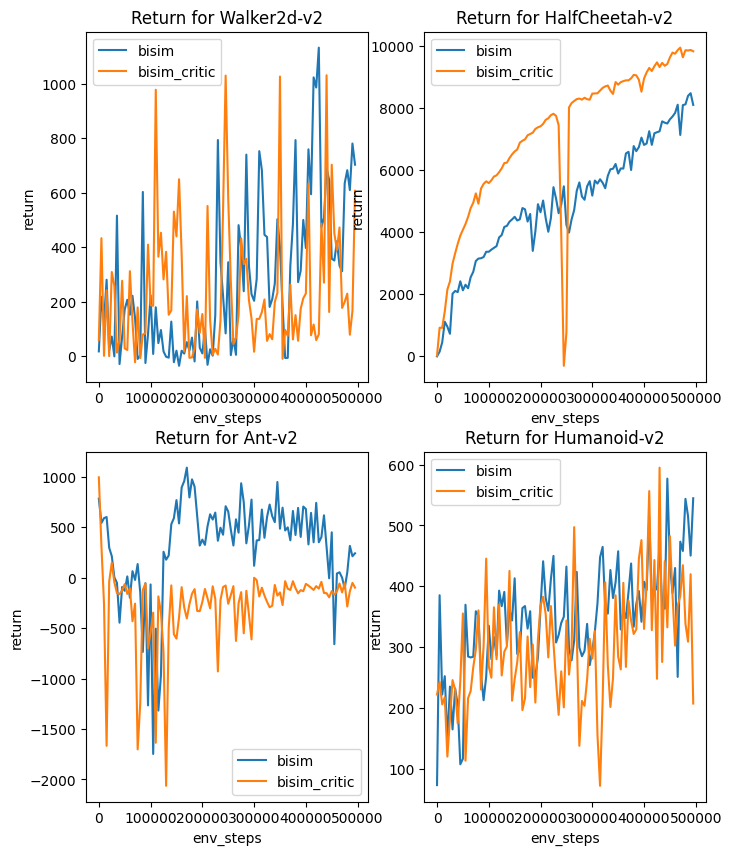

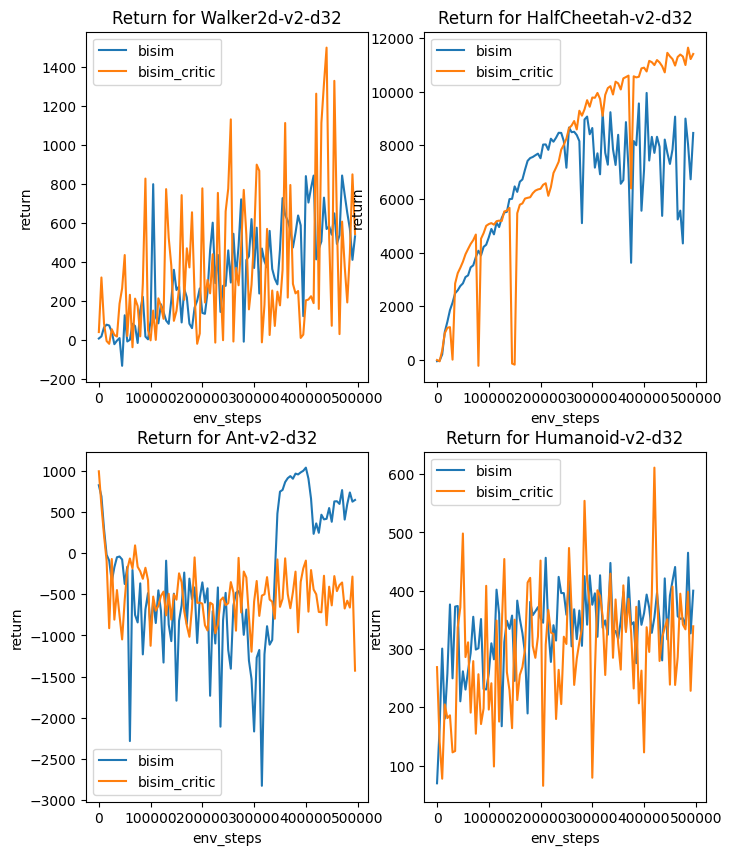

In [5]:
plot_results(envs, auxs, results, "return")
plot_results(distracted_envs, auxs, results, "return")

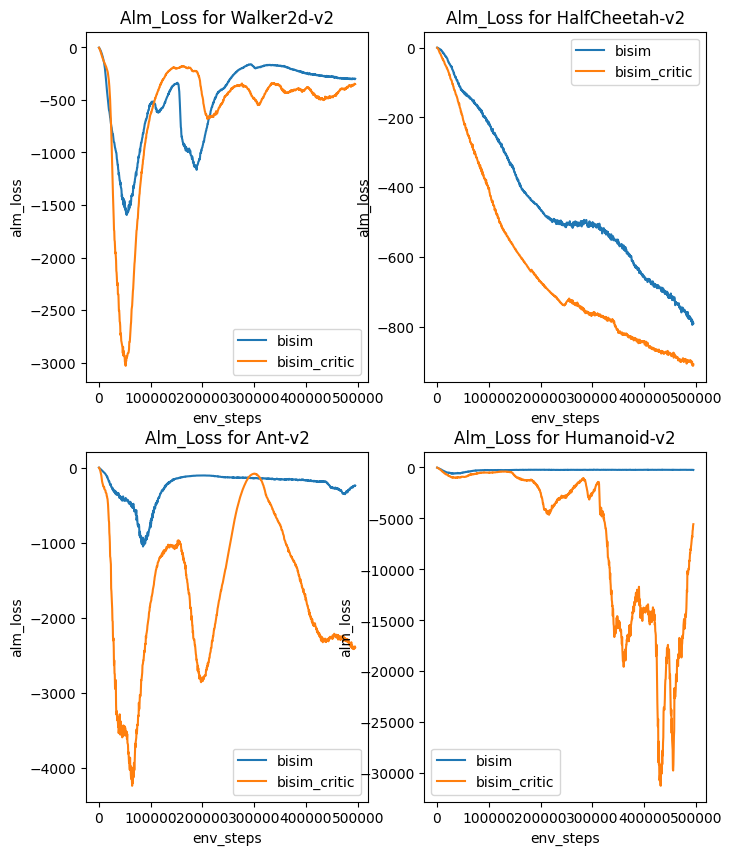

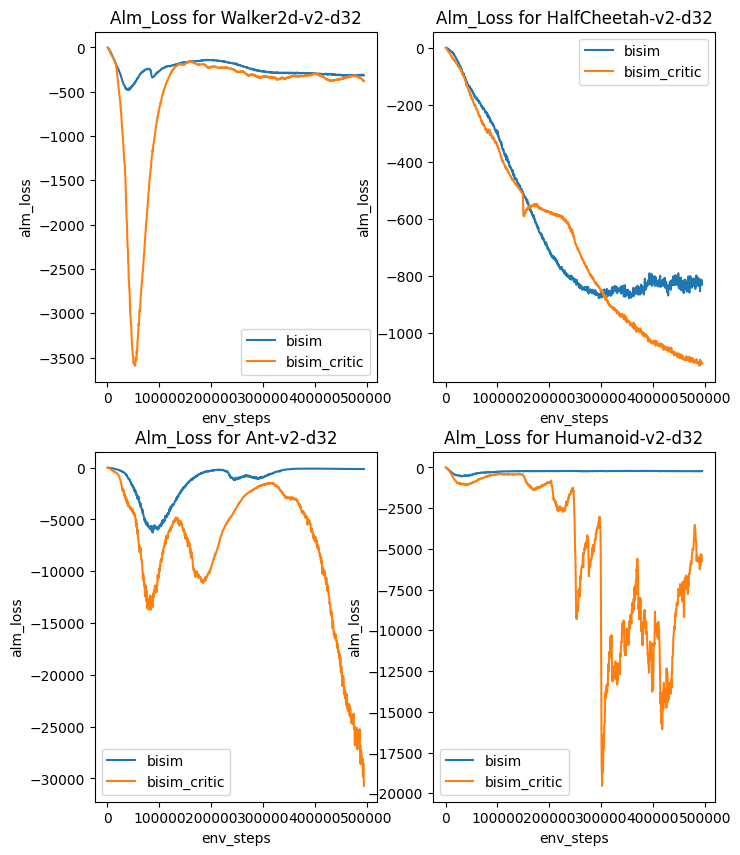

In [6]:
plot_results(envs, auxs, results, "alm_loss")
plot_results(distracted_envs, auxs, results, "alm_loss")

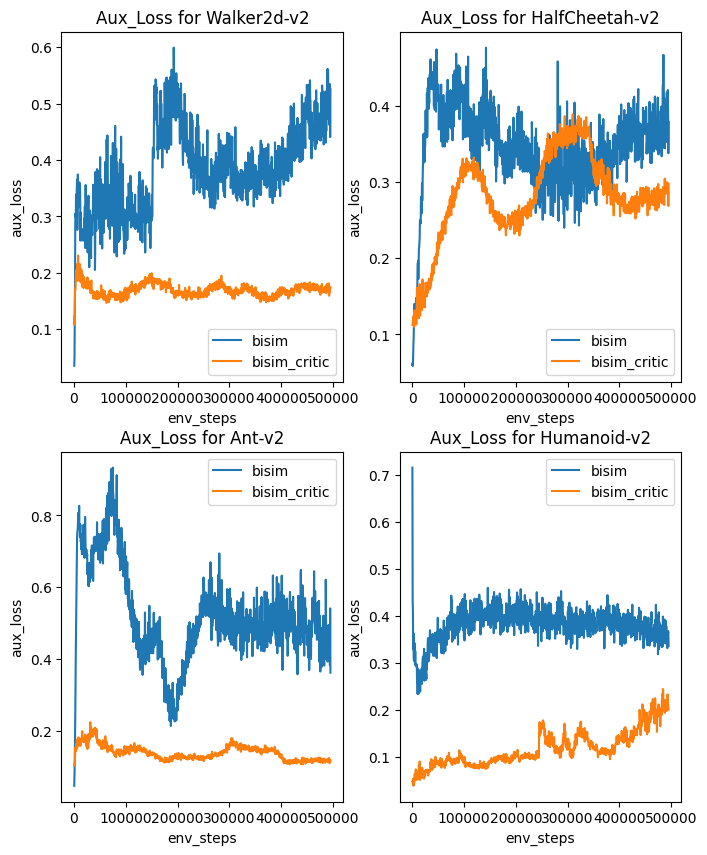

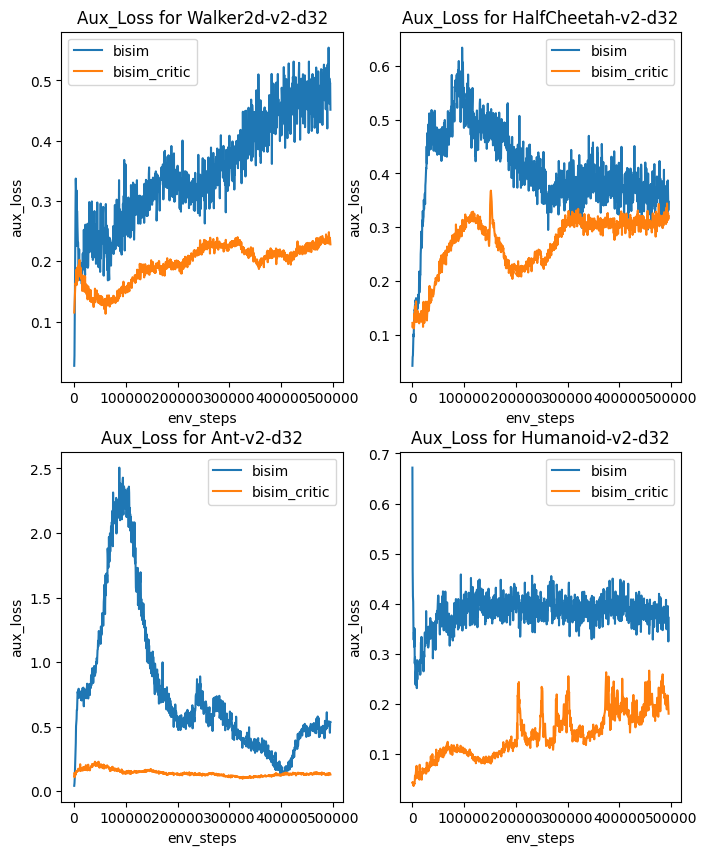

In [7]:
plot_results(envs, auxs, results, "aux_loss")
plot_results(distracted_envs, auxs, results, "aux_loss")

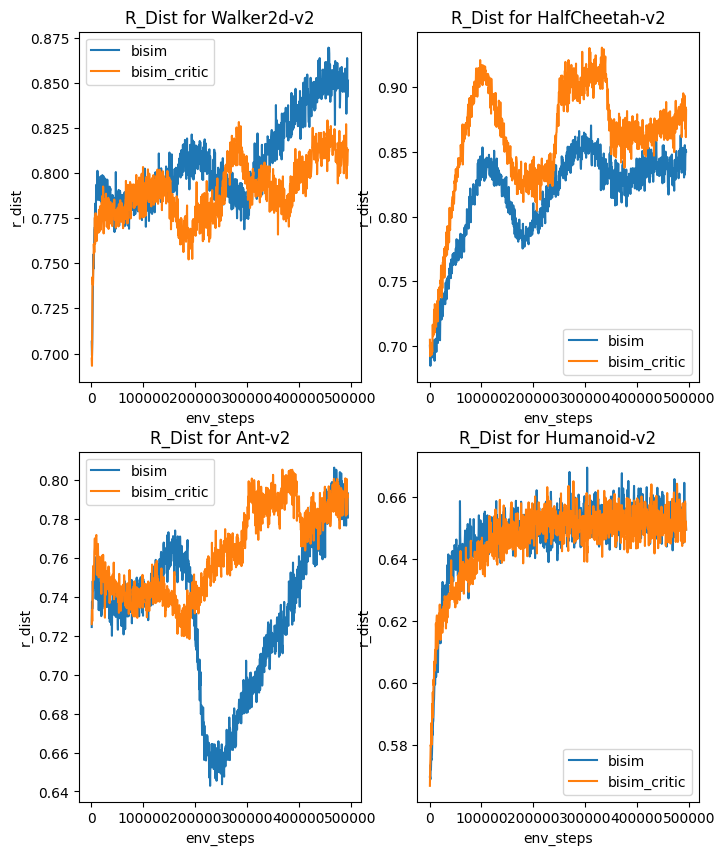

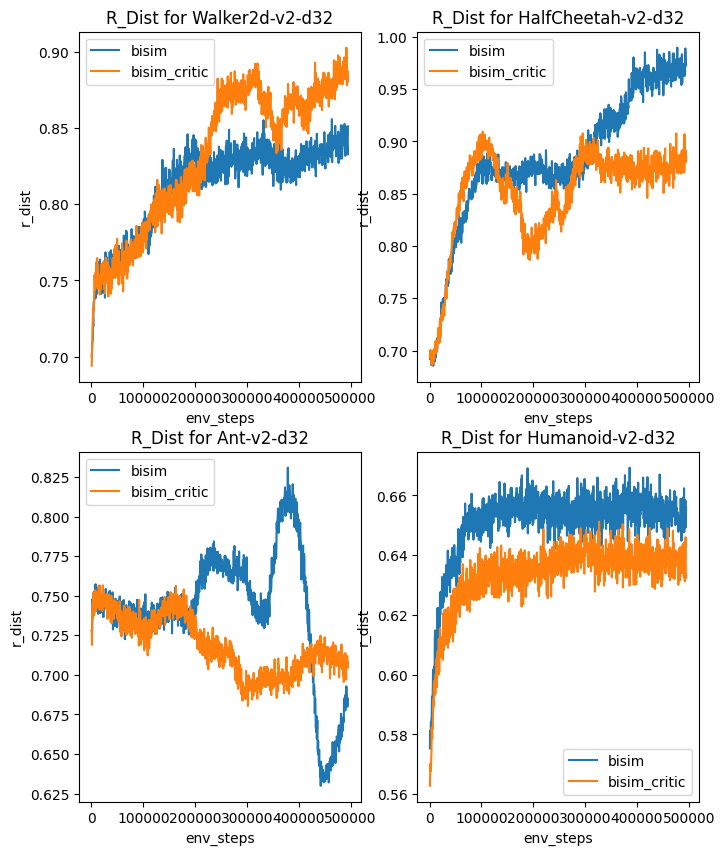

In [8]:
plot_results(envs, auxs, results, "r_dist")
plot_results(distracted_envs, auxs, results, "r_dist")

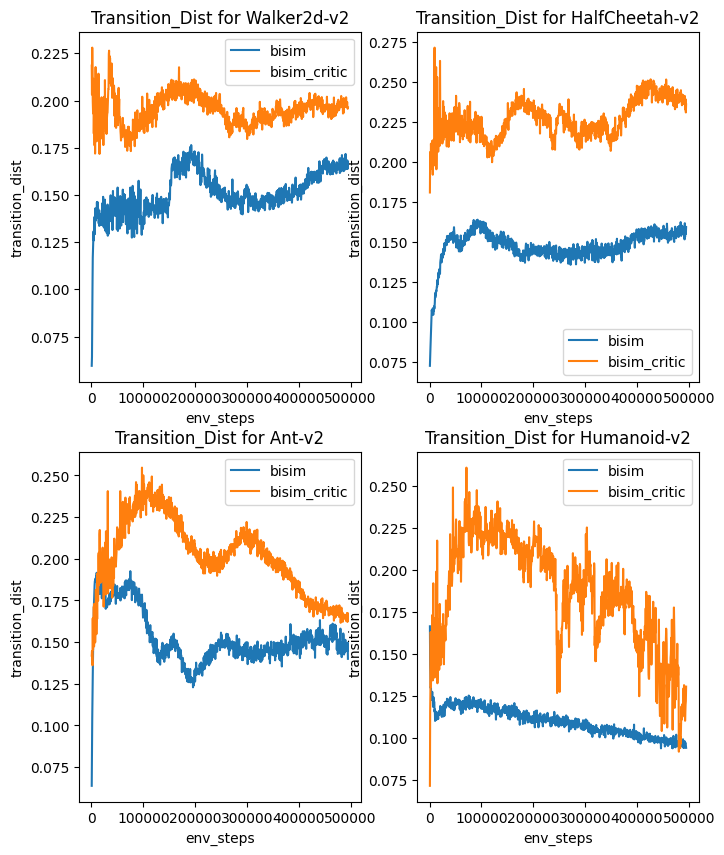

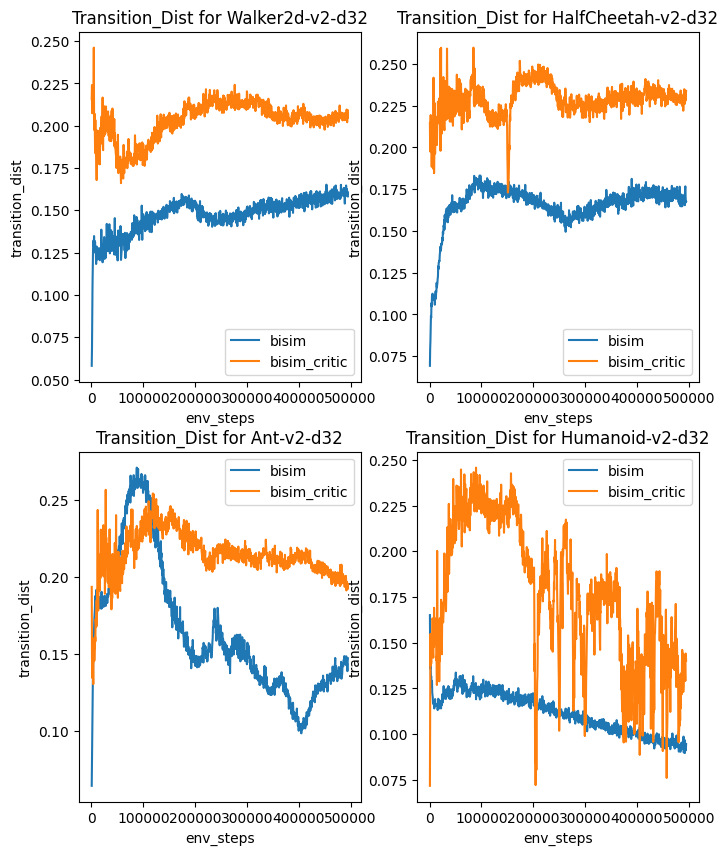

In [9]:
plot_results(envs, auxs, results, "transition_dist")
plot_results(distracted_envs, auxs, results, "transition_dist")